In [72]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import gensim

# Introduction

### Human or AI?

Can texts be classified based on if they were written by a human or AI?  
This modeling exploration goes about determining just that.   
In the following notebook, there will be comparisons with two different feature extraction techniques, TF-IDF (Term Frequency-Inverse Document Frequency) and Word2Vec. TF-IDF is frequency based and won't capture context as well as Word2Vec, but has a much faster training time and has a higher interpretability.
Along with that, three different models will be explored: Logistic Regression (simplest, most interpretable), Random Forest Classifier, and SVCLinear (a linear SVM implementation).

In [3]:
# load dataset (obtained from kaggle)
ai_human = pd.read_csv("AI_Human.csv")
ai_human.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


# Exploratory Data Analysis

In [5]:
print(f'Missing data: \n{ai_human.isnull().sum()}')

Missing data: 
text         0
generated    0
dtype: int64


In [6]:
ai_human['generated'].value_counts()

generated
0.0    305797
1.0    181438
Name: count, dtype: int64

There is a moderate class imbalance, which will be something to keep in mind as the modeling continues. This will be particularly important when evaluating the models: precision, recall, and F1 scores will be of interest.

# Text Preprocessing

Clean the text to ensure there is consistency throughout (no noise and consistent formatting)

In [8]:
def clean_text(text):
    # take away leading and trailing whitespaces
    clean = text.strip()
    # regex: look behind - 
    # add a period where there is a newline (unless there is already a period there)
    clean = re.sub(r'(?<!\.)\n+', '. ', clean)
    # take away all extra spaces before periods
    clean = re.sub(r'\s+([.])', r'\1', clean)
    # replace all multiple spaces with a single space
    clean = re.sub(r'\s+', ' ', clean)
    # remove multiple periods with 1 period
    clean = re.sub(r'\.{2,}', '.', clean)
    # if the string doesn't end with with a period...
    if not clean.endswith('.'):
        # append a period to the end
        clean += '.'
    return clean

ai_human['cleaned_text'] = ai_human['text'].apply(clean_text)

In [9]:
ai_human.head()

,text,generated,cleaned_text
0,Cars. Cars have been around since they became ...,0.0,Cars. Cars have been around since they became ...
1,Transportation is a large necessity in most co...,0.0,Transportation is a large necessity in most co...
2,"""America's love affair with it's vehicles seem...",0.0,"""America's love affair with it's vehicles seem..."
3,How often do you ride in a car? Do you drive a...,0.0,How often do you ride in a car? Do you drive a...
4,Cars are a wonderful thing. They are perhaps o...,0.0,Cars are a wonderful thing. They are perhaps o...


# Feature Extraction

This is done to represent the input data numerically.

### TF-IDF

In [12]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(ai_human['cleaned_text'])

### Word2Vec

In [14]:
sentences = ai_human['cleaned_text'].apply(str.split).tolist()
# Train a Word2Vec model
# vector_size=100 is embedding size
# window=5 is context window,
# min_count=1 includes all words that appear at least once, 
# workers=4 is for parallel training
# see here: https://radimrehurek.com/gensim/models/word2vec.html
model_w2v = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# will use this function to split data later
def avg_word2vec(text):
    words = text.split()
    # get vectors for words that exist in Word2Vec vocabulary
    vectors = [model_w2v.wv[word] for word in words if word in model_w2v.wv]
    # return the average vector or 0 if none exist
    return np.mean(vectors, axis=0) if vectors else np.zeros(model_w2v.vector_size)

# Models

### Split the dataset

For TF-IDF and Word2Vec, split the datasets into training and testing sets for model training and evaluation.

#### TF-IDF

In [18]:
y_tfidf = ai_human['generated']

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)

#### Word2Vec

In [20]:
# stack the word2vec vectors into an array
X_w2v = np.vstack(ai_human['cleaned_text'].apply(avg_word2vec).values)
y_w2v = ai_human['generated']

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.2, random_state=42)

### Training and Predicting

### Logistic Regression

In [22]:
# TF-IDF
tfidf_lr = LogisticRegression()
tfidf_lr.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf_lr = tfidf_lr.predict(X_test_tfidf)

# Word2Vec
w2v_lr = LogisticRegression()
w2v_lr.fit(X_train_w2v, y_train_w2v)
y_pred_w2v_lr = w2v_lr.predict(X_test_w2v)

### Random Forest

Parameters are specified here for runtime purposes

In [24]:
# TF-IDF
tfidf_rf = RandomForestClassifier(
    n_estimators=50,        # default = 100
    max_depth=20,           # limit tree depth
    n_jobs=-1,              # use all CPU cores
    random_state=42         
)
tfidf_rf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf_rf = tfidf_rf.predict(X_test_tfidf)

# Word2Vec
w2v_rf = RandomForestClassifier(
    n_estimators=50,        # default = 100
    max_depth=20,           # limit tree depth
    n_jobs=-1,              # use all CPU cores
    random_state=42         
)
w2v_rf.fit(X_train_w2v, y_train_w2v)
y_pred_w2v_rf = w2v_rf.predict(X_test_w2v)

### SVM

Parameter specified here for runtime purposes

In [26]:
# TF-IDF
tfidf_svm = LinearSVC(dual=False)
tfidf_svm.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf_svm = tfidf_svm.predict(X_test_tfidf)

# Word2Vec
w2v_svm = LinearSVC(dual=False)
w2v_svm.fit(X_train_w2v, y_train_w2v)
y_pred_w2v_svm = w2v_svm.predict(X_test_w2v)

# Evaluation

#### TF-IDF

Logistic Regression Accuracy: 0.9933604933964103
Random Forest Accuracy: 0.9848840908391228
SVM Accuracy: 0.9976500046178949
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     61112
         1.0       1.00      0.99      0.99     36335

    accuracy                           0.99     97447
   macro avg       0.99      0.99      0.99     97447
weighted avg       0.99      0.99      0.99     97447

Confusion Matrix (Random Forest):


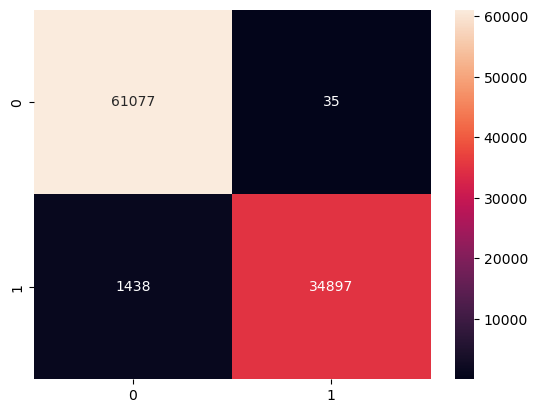

In [31]:
print(f"Logistic Regression Accuracy: {accuracy_score(y_test_tfidf, y_pred_tfidf_lr)}")
print(f"Random Forest Accuracy: {accuracy_score(y_test_tfidf, y_pred_tfidf_rf)}")
print(f"SVM Accuracy: {accuracy_score(y_test_tfidf, y_pred_tfidf_svm)}")

print("Classification Report (Logistic Regression):")
print(classification_report(y_test_tfidf, y_pred_tfidf_lr))

print("Confusion Matrix (Random Forest):")
sns.heatmap(confusion_matrix(y_test_tfidf, y_pred_tfidf_rf), annot=True, fmt="d")
plt.show()

#### Word2Vec

Logistic Regression Accuracy: 0.9800917421777993
Random Forest Accuracy: 0.9888041704721541
SVM Accuracy: 0.9802969819491621
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     61112
         1.0       0.98      0.97      0.97     36335

    accuracy                           0.98     97447
   macro avg       0.98      0.98      0.98     97447
weighted avg       0.98      0.98      0.98     97447

Confusion Matrix (Random Forest):


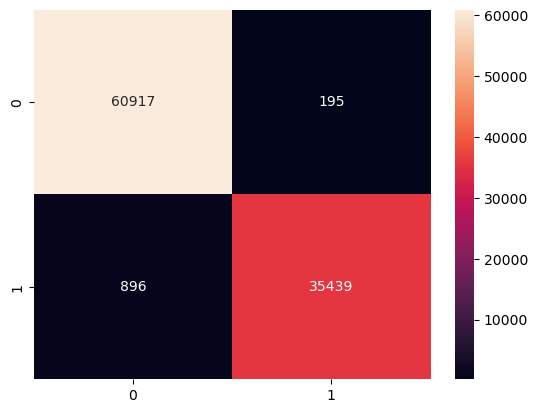

In [38]:
print(f"Logistic Regression Accuracy: {accuracy_score(y_test_w2v, y_pred_w2v_lr)}")
print(f"Random Forest Accuracy: {accuracy_score(y_test_w2v, y_pred_w2v_rf)}")
print(f"SVM Accuracy: {accuracy_score(y_test_w2v, y_pred_w2v_svm)}")

print("Classification Report (Logistic Regression):")
print(classification_report(y_test_w2v, y_pred_w2v_lr))

print("Confusion Matrix (Random Forest):")
sns.heatmap(confusion_matrix(y_test_w2v, y_pred_w2v_rf), annot=True, fmt="d")
plt.show()

# Model Comparison

#### TF-IDF

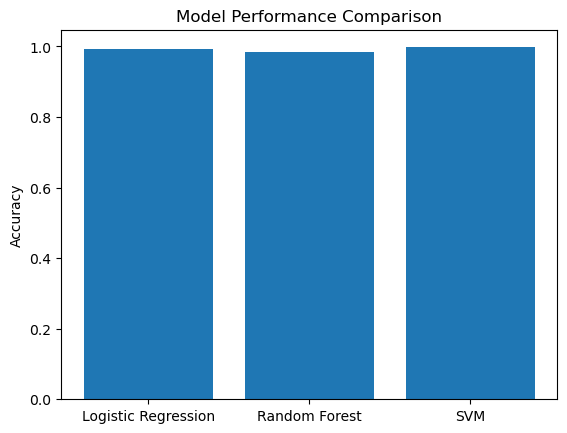

In [40]:
models = ['Logistic Regression', 'Random Forest', 'SVM']
accuracies = [accuracy_score(y_test_tfidf, y_pred_tfidf_lr), 
              accuracy_score(y_test_tfidf, y_pred_tfidf_rf), 
              accuracy_score(y_test_tfidf, y_pred_tfidf_svm)]

plt.bar(models, accuracies)
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.show()

#### Word2Vec

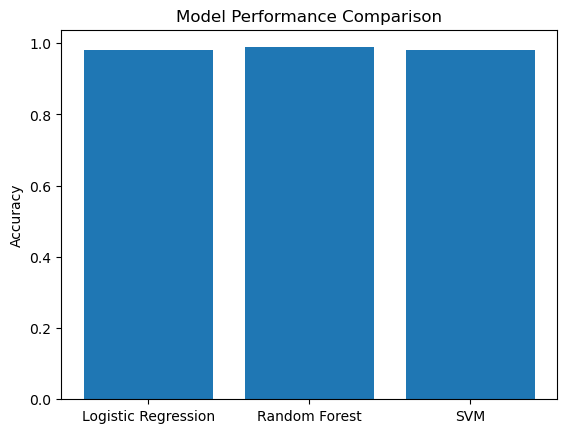

In [46]:
models = ['Logistic Regression', 'Random Forest', 'SVM']
accuracies = [accuracy_score(y_test_w2v, y_pred_w2v_lr), 
              accuracy_score(y_test_w2v, y_pred_w2v_rf), 
              accuracy_score(y_test_w2v, y_pred_w2v_svm)]

plt.bar(models, accuracies)
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.show()

#### Important Features

In [92]:
feature_names = tfidf.get_feature_names_out()

##### Random Forest

In [52]:
importances = tfidf_rf.feature_importances_
# sort in descending order, select the top 10
top_indices = importances.argsort()[-10:][::-1]
# map indices to feature names
top_features = pd.Series(importances[top_indices], index=[feature_names[i] for i in top_indices])
print(top_features)

because         0.046316
additionally    0.021666
conclusion      0.019593
would           0.018523
you             0.016539
get             0.015026
the             0.014977
go              0.014192
what            0.013869
just            0.013706
dtype: float64


##### Logistic Regression

In [94]:
coefficients = tfidf_lr.coef_[0]
# dataframe with feature names and their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
# sort by the absolute value for more important features
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
print(feature_importance.head(10))

           Feature  Coefficient  Abs_Coefficient
534        because   -22.466931        22.466931
2329     important    13.006877        13.006877
160   additionally    11.412439        11.412439
4745          very   -11.345504        11.345504
3402     potential    10.795497        10.795497
1003    conclusion    10.755535        10.755535
1636         essay    10.351723        10.351723
263       although    -9.539250         9.539250
2265       however     9.522677         9.522677
3269       percent    -9.021920         9.021920


Positive coefficients = AI
Negative coefficients = Human

# Conclusion

All of the tested models were highly efficient with both TF-IDF and Word2Vec in determining if the text presented was written by a human or AI. Precision, recall, and accuracy were very high for all models, which means the class imbalance seen in the exploratory data analysis did not significantly impact the models.  
  
Thus, selecting the most interpretible and simple model is the best choice: Logistic Regression using TF-IDF.  
  
To illustrate the interpretability, we can see the top 10 most influencial words for the Logistic Regression model decision making (see above). This shows that the model used words such as "because", "very", "although", and "percent" to determine human writing and words such as "important", "additionally", "potential", and "conclusion" to determine AI writing.